<a href="https://colab.research.google.com/github/akanksha-th/Facial_Emotion_Recognition/blob/main/FER_Custom_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
! pip install seaborn

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow
from PIL import Image
import seaborn as sns
import imghdr

In [2]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle.kaggle/! mkdir

!kaggle datasets download -d msambare/fer2013

cp: target 'mkdir' is not a directory
Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 96% 58.0M/60.3M [00:03<00:00, 24.5MB/s]
100% 60.3M/60.3M [00:03<00:00, 17.4MB/s]


In [3]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

# SETTING UP THE DIRECTORIES

In [4]:
project_name = "Emotion_Detection_using_FER2013_Dataset"

model_names = ['Custom_CNN_from_scratch',
               'Custom_CNN_with_Augmentation',
               'VGG16_Transfer_Learning',
               'Resnet_50_Transfer_Learning']

project_dir = os.path.join('/content/', project_name)
os.makedirs("project_dir", exist_ok=True)

try:
  for model in model_names:
    model_dir = os.path.join(project_dir, model)
    os.makedirs(model_dir, exist_ok=True)
except:
  print("THERE WAS SOME ISSUE WITH CREATING DIREACTORIES!!")

# DATA CLEANING AND ANALYSIS

In [5]:
img_ext = ['jpeg', 'jpg', 'png']
image_dir = '/content/train'

for root, dirs, files in os.walk(image_dir):
  for file in files:
    file_path = os.path.join(root, file)
    try:
      file_type = imghdr.what(file_path)
      if file_type not in img_ext:
        print(f'Image not in ext list {file_path}')
        os.remove(file_path)
      else:
        img = cv2.imread(file_path)
    except Exception as e:
      print(f'You are facing {e}')
      os.remove(file_path)

In [6]:
def num_files(directory, folder):
  counts = {}
  for item in os.listdir(directory):
    item_path = os.path.join(directory, item)
    if os.path.isdir(item_path):
      counts[item] = len(os.listdir(item_path))
  #print(counts)
  df = pd.DataFrame(counts, index=[folder])
  return df

train_dir = '/content/train'
test_dir = '/content/test'

train_count = num_files(train_dir, 'train')
print(train_count)

test_count = num_files(test_dir, 'test')
print(test_count)

       angry  happy  neutral  disgust  surprise  fear   sad
train   3995   7215     4965      436      3171  4097  4830
      angry  happy  neutral  disgust  surprise  fear   sad
test    958   1774     1233      111       831  1024  1247


<Axes: >

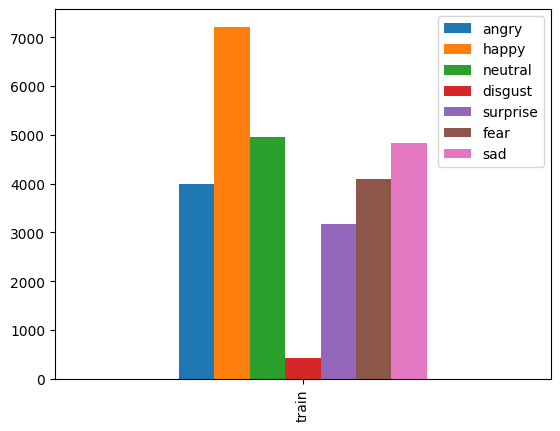

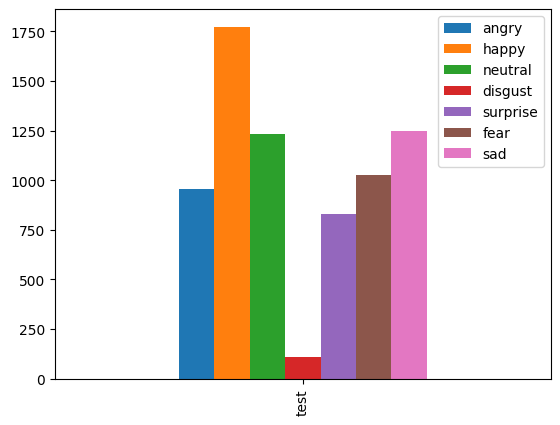

In [7]:
# Visualizing data distribution
train_count.plot(kind='bar')
test_count.plot(kind='bar')

In [8]:
#CHECKING IMAGE SHAPE

import cv2
#demo_image = "/content/train/disgust/Training_10371709.jpg"
demo_image = "/content/train/sad/Training_10057152.jpg"
demo = cv2.imread(demo_image)
demo.shape

(48, 48, 3)

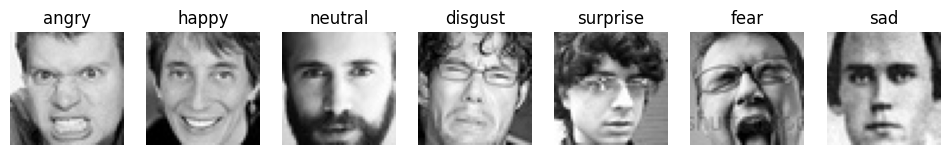

In [9]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(12,7))
#print(emotions)

for i, item in enumerate(emotions, 1):
  folder_path = os.path.join(train_dir, item)

  #image_path = os.path.join(folder_path, os.listdir(folder_path)[37])
  #image_path = os.path.join(folder_path, os.listdir(folder_path)[7])
  image_path = os.path.join(folder_path, os.listdir(folder_path)[28])

  img = plt.imread(image_path)
  plt.subplot(1, 7, i)
  plt.imshow(img, cmap='gray')
  plt.title(item)
  plt.axis('off')

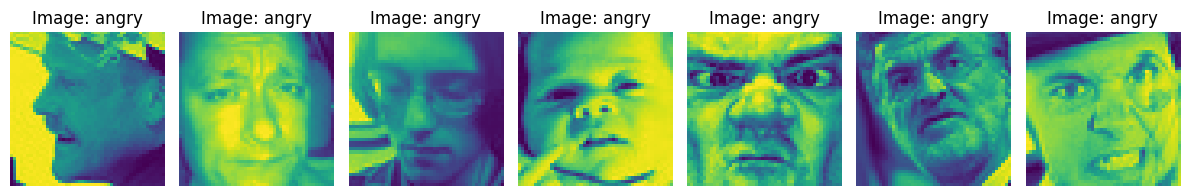

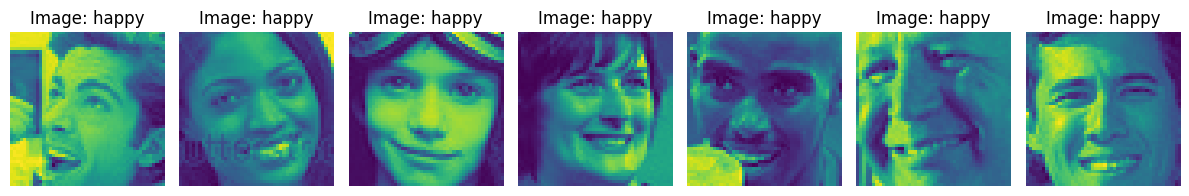

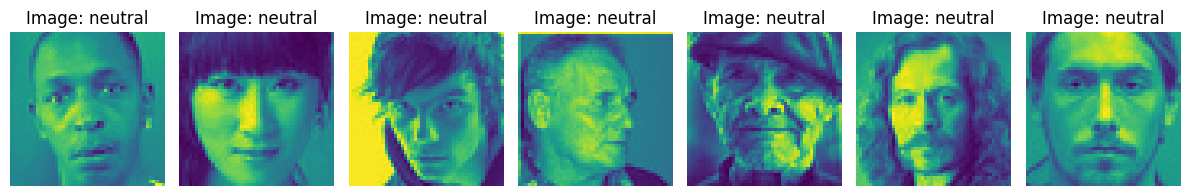

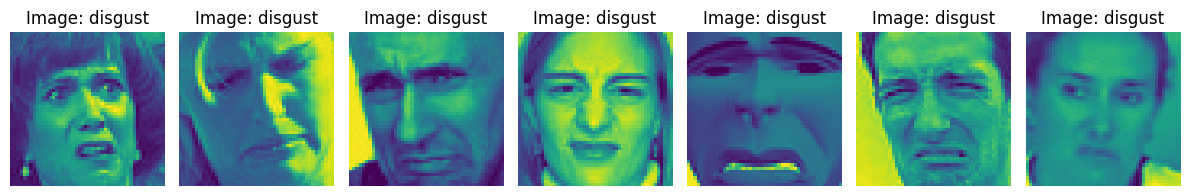

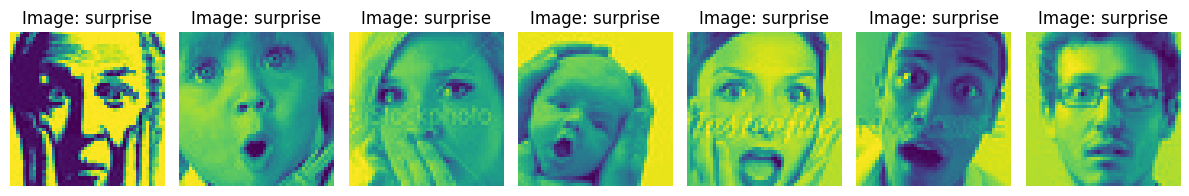

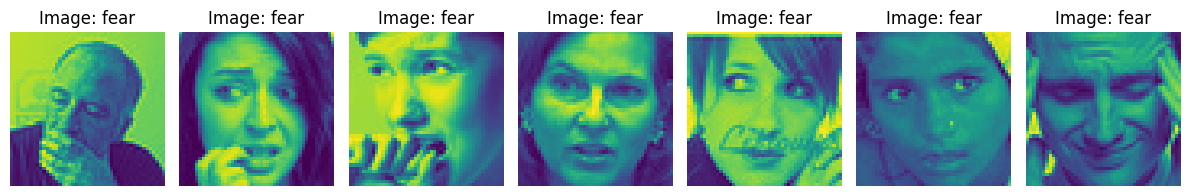

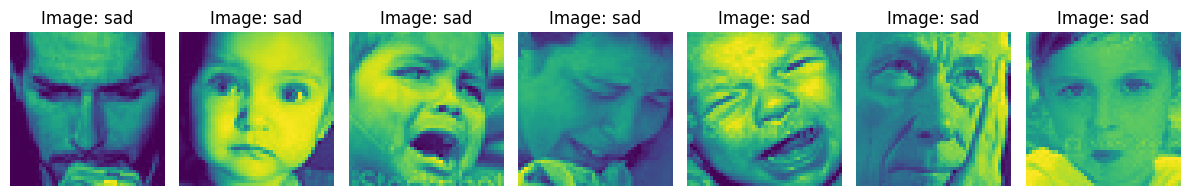

In [10]:
def plot_images_from_directory(directory, class_name, num_images=7):
  image_filenames = os.listdir(directory)
  if len(image_filenames) < num_images:
    print("NOT SUFFICIENT IMAGES IN THE DIRECTORY, HENCE AUTOMATICALLY REDUCING THE NUMBER OF IMAGES TO BE PRINTED")
    num_images = len(image_filenames)

  selected_images = random.sample(image_filenames, num_images)

  fig, axes = plt.subplots(1,num_images, figsize=(12,10))
  axes = axes.ravel()

  for i, image_file in enumerate(selected_images):
    image_path = os.path.join(directory, image_file)
    image = plt.imread(image_path)
    axes[i].imshow(image)
    axes[i].set_title(f"Image: {class_name}")
    axes[i].axis('off')

  plt.tight_layout()
  plt.show()

for emotion in emotions:
  folder_path = os.path.join(train_dir, emotion)
  plot_images_from_directory(folder_path, class_name = emotion)

# BUILDING THE MODELS

### MODEL 1: CUSTOM CNN FROM SCRATCH



In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initializing Image Generators
train_dir = '/content/train'
test_dir = '/content/test'

img_H, img_W = demo.shape[:-1]
batch_size = 64
epochs = 30
num_classes = len(os.listdir(train_dir))

# Rescaling the pixel values (0-255)---->[0, 1]
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data_generator = data_generator.flow_from_directory(
    train_dir,
    target_size = (img_H, img_W),
    batch_size = batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_data_generator = data_generator.flow_from_directory(
    train_dir,
    target_size = (img_H, img_W),
    batch_size = batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_data_generator = data_generator.flow_from_directory(
    test_dir,
    target_size = (img_H, img_W),
    batch_size = batch_size,
    class_mode='categorical',
    color_mode='grayscale')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [36]:
train_class_labels = train_data_generator.class_indices
print("Training class labels:", train_class_labels)
print('----------------------------------------------')
validation_class_labels = validation_data_generator.class_indices
print("Validation class labels:", validation_class_labels)
print('----------------------------------------------')
test_class_labels = test_data_generator.class_indices
print("Testing class labels:", test_class_labels)
print('----------------------------------------------')

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
----------------------------------------------
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
----------------------------------------------
Testing class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
----------------------------------------------


In [37]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [48]:
model = Sequential()
model.add(Conv2D(3, 32, kernel_initializer="glorot_uniform", padding='same', input_shape=(img_W, img_H, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(96, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(384, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

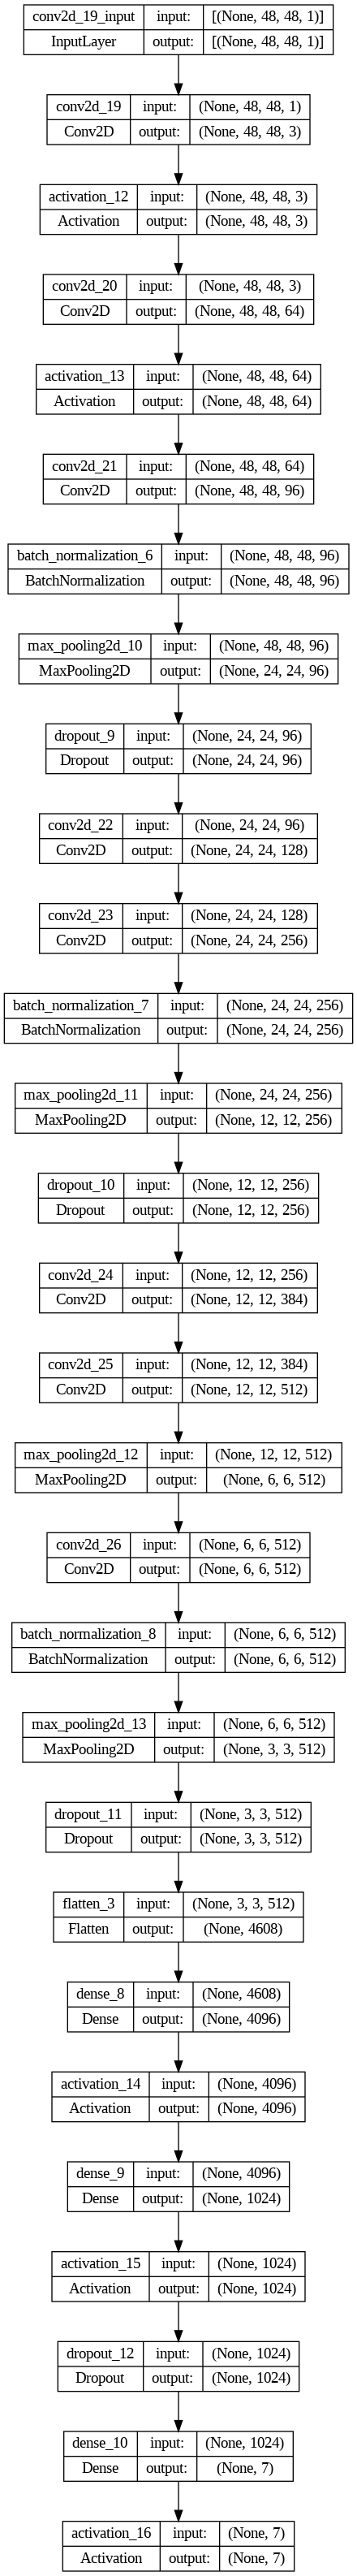

In [49]:
#model.summary()
os.makedirs('model_architectures', exist_ok=True)
plot_model(model, to_file ='model_architectures/Custom-CNN-from-scratch-architecture.png', show_shapes=True, show_layer_names=True)

In [50]:
model_path = os.path.join('/content/Emotion_Detection_using_FER2013_Dataset/Custom_CNN_from_scratch', 'Custom_CNN_model.keras')

checkpoint = ModelCheckpoint(filepath=model_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger(os.path.join('/content/Emotion_Detection_using_FER2013_Dataset/Custom_CNN_from_scratch','training.log'))

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [51]:
train_steps_per_epoch = train_data_generator.samples // train_data_generator.batch_size + 1
validation_steps_per_epoch = validation_data_generator.samples // validation_data_generator.batch_size + 1
test_steps_per_epoch = test_data_generator.samples // test_data_generator.batch_size + 1

In [52]:
history = model.fit(
    train_data_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epochs,
    validation_data=validation_data_generator,
    validation_steps=validation_steps_per_epoch,
    callbacks=callbacks)

Epoch 1/30
359/359 [==============================] - ETA: 0s - loss: 6.4616 - accuracy: 0.2294
Epoch 1: val_loss improved from inf to 24.45335, saving model to /content/Emotion_Detection_using_FER2013_Dataset/Custom_CNN_from_scratch/Custom_CNN_model.keras
359/359 [==============================] - 37s 89ms/step - loss: 6.4616 - accuracy: 0.2294 - val_loss: 24.4534 - val_accuracy: 0.1392 - lr: 0.0010
Epoch 2/30
359/359 [==============================] - ETA: 0s - loss: 1.9613 - accuracy: 0.2565
Epoch 2: val_loss improved from 24.45335 to 1.88552, saving model to /content/Emotion_Detection_using_FER2013_Dataset/Custom_CNN_from_scratch/Custom_CNN_model.keras
359/359 [==============================] - 32s 88ms/step - loss: 1.9613 - accuracy: 0.2565 - val_loss: 1.8855 - val_accuracy: 0.2700 - lr: 0.0010
Epoch 3/30
359/359 [==============================] - ETA: 0s - loss: 1.8004 - accuracy: 0.2904
Epoch 3: val_loss improved from 1.88552 to 1.78286, saving model to /content/Emotion_Detectio

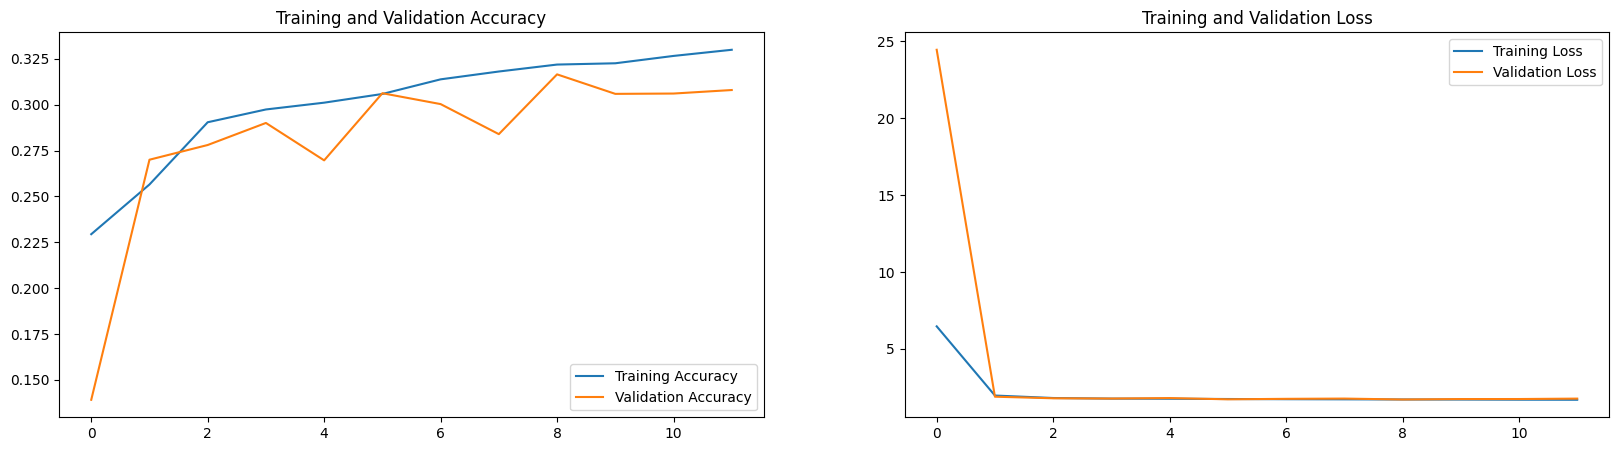

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [54]:
train_loss, train_accu = model.evaluate(train_data_generator)
test_loss, test_accu = model.evaluate(test_data_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 3s 30ms/step - loss: 1.6806 - accuracy: 0.3371
final train accuracy = 33.39 , validation accuracy = 33.71


113/113 [==============================] - 3s 21ms/step


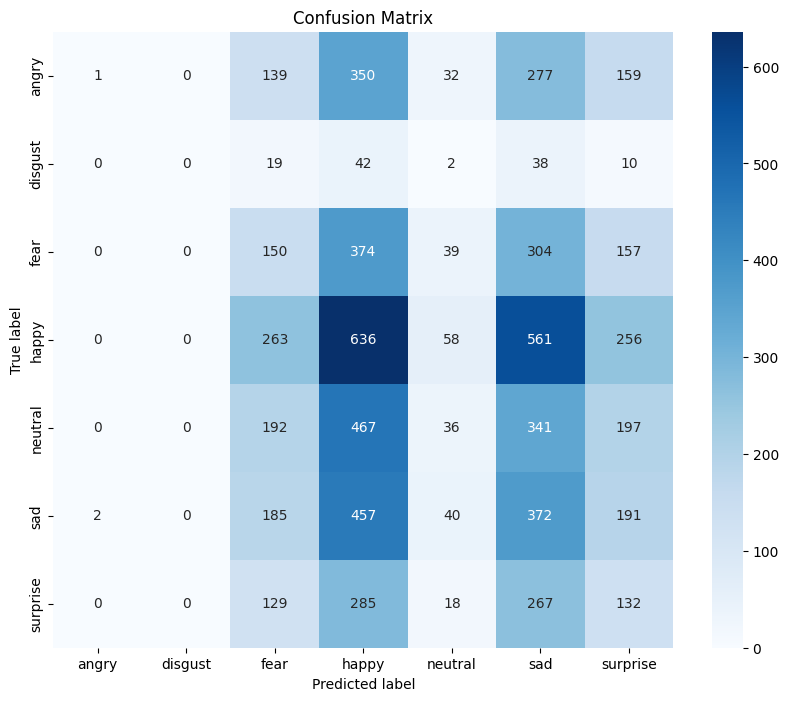

In [55]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_data_generator.classes
predicted_classes = np.argmax(model.predict(test_data_generator, steps=np.ceil(test_data_generator.samples/test_data_generator.batch_size)), axis=1)
class_labels = list(test_data_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [56]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.33      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.14      0.15      0.14      1024
       happy       0.24      0.36      0.29      1774
     neutral       0.16      0.03      0.05      1233
         sad       0.17      0.30      0.22      1247
    surprise       0.12      0.16      0.14       831

    accuracy                           0.18      7178
   macro avg       0.17      0.14      0.12      7178
weighted avg       0.20      0.18      0.15      7178



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


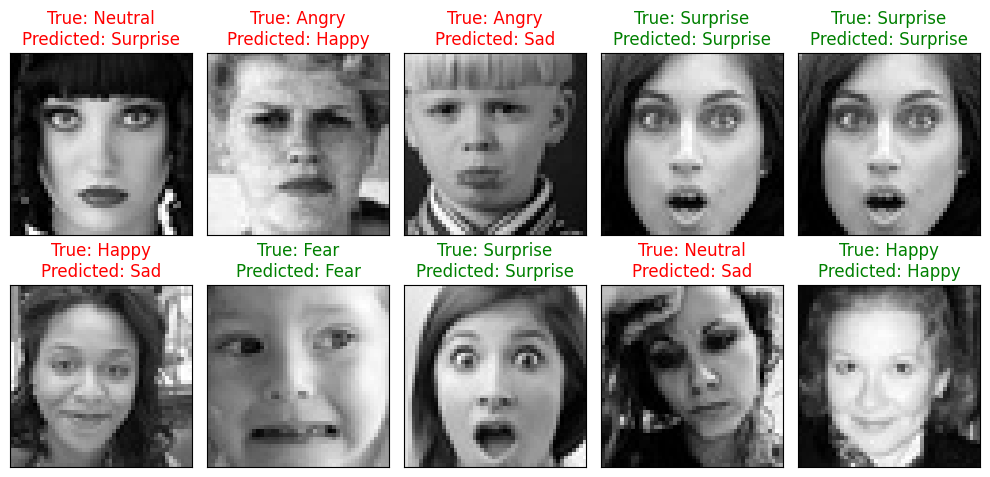

In [62]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_data_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_data_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_data_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_data_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()